### StratifiedGroupKFold를 이용해 validation set 생성

- 대회가 어느정도 막바지를 향해가면, n_split을  큰 값으로 늘려, OOF를 진행해볼 수 있을 것 같다

In [1]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

# load json 
annotation = 'dataset/train.json'

with open(annotation) as f:
    data = json.load(f)

var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]

X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])  # class
groups = np.array([v[0] for v in var])  # image(group)

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411)

for train_idx, val_idx in cv.split(X, y, groups):
    print("TRAIN:", groups[train_idx])
    print(" ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print(" ", y[val_idx])

TRAIN: [   0    1    1 ... 4881 4881 4881]
  [0 3 7 ... 7 1 7]
 TEST: [   6   13   13 ... 4882 4882 4882]
  [1 6 7 ... 0 1 1]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   5    5    5 ... 4876 4876 4878]
  [7 0 0 ... 0 2 0]
TRAIN: [   0    3    3 ... 4882 4882 4882]
  [0 2 6 ... 0 1 1]
 TEST: [   1    1    1 ... 4877 4877 4880]
  [3 7 4 ... 7 7 0]
TRAIN: [   1    1    1 ... 4882 4882 4882]
  [3 7 4 ... 0 1 1]
 TEST: [   0    3    3 ... 4881 4881 4881]
  [0 2 6 ... 7 1 7]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   4    4    4 ... 4868 4872 4872]
  [1 1 1 ... 2 4 6]


In [58]:
# check distribution
import pandas as pd
from collections import Counter

def get_distribution(y):
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values())

    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y) +1)]

distrs = [get_distribution(y)]
index = ['training set']

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)):
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx]

    assert len(set(train_gr) & set(val_gr)) == 0 
    
    distrs.append(get_distribution(train_y))
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')
    
categories = [d['name'] for d in data['categories']]
pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,17.14%,27.45%,3.88%,4.04%,4.24%,12.72%,5.46%,22.37%,0.69%,2.02%
train - fold0,16.96%,27.45%,3.79%,4.13%,4.48%,12.61%,5.51%,22.28%,0.77%,2.02%
val - fold0,17.85%,27.42%,4.23%,3.70%,3.26%,13.15%,5.25%,22.77%,0.35%,2.02%
train - fold1,17.14%,27.24%,4.01%,3.98%,4.28%,12.77%,5.38%,22.32%,0.67%,2.20%
val - fold1,17.12%,28.17%,3.41%,4.26%,4.12%,12.51%,5.72%,22.57%,0.73%,1.38%
train - fold2,17.31%,27.39%,3.83%,4.08%,4.13%,12.80%,5.14%,22.68%,0.69%,1.94%
val - fold2,16.42%,27.68%,4.05%,3.88%,4.70%,12.36%,6.76%,21.12%,0.69%,2.35%
train - fold3,17.30%,27.47%,3.87%,4.06%,4.22%,12.63%,5.49%,22.39%,0.63%,1.95%
val - fold3,16.50%,27.36%,3.88%,3.99%,4.33%,13.07%,5.33%,22.30%,0.92%,2.32%
train - fold4,16.97%,27.67%,3.88%,3.97%,4.10%,12.77%,5.76%,22.20%,0.68%,2.00%


In [56]:
train_val_df = pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])
fold0_gap = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[1].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[2].to_list())))))
fold1_gap = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[3].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[4].to_list())))))
fold2_gap = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[5].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[6].to_list())))))
fold3_gap = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[7].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[8].to_list())))))
fold4_gap = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[9].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[10].to_list())))))
print(fold0_gap,fold1_gap,fold2_gap,fold3_gap,fold4_gap)

4.719999999999998 3.7200000000000024 6.199999999999997 2.4499999999999993 6.190000000000001


In [57]:
fold0_gap_trainingset = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[0].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[2].to_list())))))
fold1_gap_trainingset = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[0].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[4].to_list())))))
fold2_gap_trainingset = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[0].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[6].to_list())))))
fold3_gap_trainingset = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[0].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[8].to_list())))))
fold4_gap_trainingset = np.sum(np.abs(np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[0].to_list()))) - np.array(list(map(lambda x:float(x[:-1]), train_val_df.iloc[10].to_list())))))
print(fold0_gap_trainingset,fold1_gap_trainingset,fold2_gap_trainingset,fold3_gap_trainingset,fold4_gap_trainingset)

3.7899999999999974 2.9000000000000017 4.98 1.9499999999999997 5.0399999999999965


- competition에서 주어진 training set과 test set이 random하게 split되었고, 두 set 간의 분포가 유사할 것이라는 가정하에, fold 내에서의 train, val의 차이가 가장 작으면서, valset이 기존 training set의 분포와 가장 비슷하기에 test set을 가장 잘 대변할 것으로 추측되는 fold3에서의 train과 val을 모델학습의 train과 val로 사용

In [64]:
import pandas as pd
from collections import Counter

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)):
    
    if fold_ind==3:
        fold3_best_train = groups[train_idx]
        fold3_best_val = groups[val_idx]
    
print(fold3_best_train)
print(fold3_best_val)

# train, val 각각으로 사용할 image index 추출

[   1    1    1 ... 4882 4882 4882]
[   0    3    3 ... 4881 4881 4881]


- json으로 추출

In [85]:
train_idx_list = list(set(fold3_best_train))  # json파일 내의 images, annotations를 수정해야함
val_idx_list = list(set(fold3_best_val))

print(f'train length: {len(train_idx_list)}, val length: {len(val_idx_list)}')

train length: 3902, val length: 981


In [95]:
json_file = data.copy()
new_data_images_train = [json_file['images'][i] for i in train_idx_list]
new_data_images_val = [json_file['images'][i] for i in val_idx_list]
print(len(new_data_images_train), len(new_data_images_val))

3902 981


In [105]:
new_ann_train = []
new_ann_val = []
for ann_id in range(len(data['annotations'])):
    ann_img_id = json_file['annotations'][ann_id]['image_id']
    if ann_img_id in train_idx_list:
        new_ann_train.append(json_file['annotations'][ann_id])
    if ann_img_id in val_idx_list:
        new_ann_val.append(json_file['annotations'][ann_id])
        
print(len(new_ann_train), len(new_ann_val))

18454 4690


In [125]:
len(json_file['annotations'])  # 18454 + 4690

23144

In [124]:
json_train = json_file.copy()
json_val = json_file.copy()

json_train['images'] = new_data_images_train
json_train['annotations'] = new_ann_train

json_val['images'] = new_data_images_val
json_val['annotations'] = new_ann_val

print(len(json_train['images']), len(json_train['annotations']))
print(len(json_val['images']), len(json_val['annotations']))

3902 18454
981 4690


In [126]:
## Json file로 생성

import json

with open('train_StfGKFold.json', 'w') as t:
    json.dump(json_train, t)

with open('val_StfGKFold.json', 'w') as v:
    json.dump(json_val, v)

## MultiLabel 

In [93]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

# load json 
annotation = '../input/data/ICDAR17_Korean/ufo/train_camper+icdar_removeErrorcase.json'

with open(annotation) as f:
    data = json.load(f)

img_list = list(data['images'].keys())

In [2]:
bbox_num_list = []
bbox_meanarea_list = []
for i in range(len(img_list)):
    bbox_wh_list = []
    bbox_area_list = []
    bbox_num = len(data['images'][img_list[i]]['words'].keys())
    for box in list(data['images'][img_list[i]]['words'].keys()):
        # print(data['images'][img_list[i]]['words'][box]['points'])
        points = data['images'][img_list[i]]['words'][box]['points']
        bbox_wh_list.append([abs(points[1][0]-points[0][0]),abs(points[3][1]-points[0][1])])
    for j in range(len(bbox_wh_list)):
        bbox_area_list.append(bbox_wh_list[j][0] * bbox_wh_list[j][1])
    bbox_meanarea_list.append(np.mean(bbox_area_list))
    bbox_num_list.append(len(bbox_area_list))

In [3]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'image':img_list, 'bbox_num':bbox_num_list, 'bbox_mean_area':bbox_meanarea_list})
df

,image,bbox_num,bbox_mean_area
0,img_4380.jpg,3,159867.000000
1,img_4583.jpg,2,325364.000000
2,img_4234.jpg,7,155851.857143
3,img_4345.jpg,7,26927.285714
4,img_4016.jpg,1,374075.000000
...,...,...,...
1233,1632653065125-29.jpg,40,32241.183373
1234,1632655308620-22.jpg,15,1686.088609
1235,1632655308620-25.jpg,27,16143.306949
1236,1632655330045-21.jpg,4,18557.875828


In [4]:
pd.options.display.float_format = '{:.5f}'.format
df.bbox_mean_area.apply(lambda x: int(x)).describe()  # bbox의 크기를 0~25, 25~50, 50~75, 75~100 총 4가지로 분류

count      1238.00000
mean     208657.75687
std      440091.22024
min           0.00000
25%       28021.75000
50%       80359.50000
75%      220970.25000
max     9600968.00000
Name: bbox_mean_area, dtype: float64

In [5]:
# 작은 box부터 큰 box까지 0,1,2,3, 이미지 별 bbox의 평균 크기 분류
area_class = []  
for i in range(1238):
    if df.iloc[i]['bbox_mean_area'] <= 28021:
        area_class.append(0)
    elif df.iloc[i]['bbox_mean_area'] <= 80359:
        area_class.append(1)
    elif df.iloc[i]['bbox_mean_area'] <= 220970:
        area_class.append(2)
    else:
        area_class.append(3)
df['area_class'] = area_class
df['image_id'] = [i for i in range(1238)]
df.head()

,image,bbox_num,bbox_mean_area,area_class,image_id
0,img_4380.jpg,3,159867.00000,2,0
1,img_4583.jpg,2,325364.00000,3,1
2,img_4234.jpg,7,155851.85714,2,2
3,img_4345.jpg,7,26927.28571,0,3
4,img_4016.jpg,1,374075.00000,3,4


In [55]:
# !pip install iterative-stratification

     |████████████████████████████████| 9.7 MB 21.6 MB/s eta 0:00:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=41)
# X = np.ones((len(bbox_num),1))
trainset_list = []
valset_list = []
for fold_ind, (train_idx, val_idx) in enumerate(cv.split(df[['image_id','bbox_num', 'area_class']], df[['bbox_num', 'area_class']])):
    
    print("TRAIN:", list(train_idx[:10]))
    print(" TEST:", list(val_idx[:10]))
    trainset_list.append(list(train_idx))
    valset_list.append(list(val_idx))

TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 TEST: [21, 28, 29, 33, 34, 37, 39, 46, 48, 49]
TRAIN: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11]
 TEST: [1, 3, 14, 16, 22, 27, 30, 32, 42, 53]
TRAIN: [0, 1, 3, 4, 5, 7, 8, 9, 10, 12]
 TEST: [2, 6, 11, 13, 15, 18, 24, 45, 58, 62]
TRAIN: [0, 1, 2, 3, 5, 6, 10, 11, 13, 14]
 TEST: [4, 7, 8, 9, 12, 17, 23, 25, 35, 38]
TRAIN: [1, 2, 3, 4, 6, 7, 8, 9, 11, 12]
 TEST: [0, 5, 10, 19, 20, 26, 31, 36, 40, 41]


In [13]:
len(trainset_list), len(valset_list)

(5, 5)

In [14]:
train_df1 = df.iloc[trainset_list[0]]
train_df2 = df.iloc[trainset_list[1]]
train_df3 = df.iloc[trainset_list[2]]
train_df4 = df.iloc[trainset_list[3]]
train_df5 = df.iloc[trainset_list[4]]

val_df1 = df.iloc[valset_list[0]]
val_df2 = df.iloc[valset_list[1]]
val_df3 = df.iloc[valset_list[2]]
val_df4 = df.iloc[valset_list[3]]
val_df5 = df.iloc[valset_list[4]]

print(train_df1.shape, train_df2.shape, train_df3.shape, train_df4.shape, train_df5.shape)
print(val_df1.shape, val_df2.shape, val_df3.shape, val_df4.shape, val_df5.shape)

(991, 5) (990, 5) (991, 5) (990, 5) (990, 5)
(247, 5) (248, 5) (247, 5) (248, 5) (248, 5)


In [74]:
train_box_num1 = [round(i/990, 3) for i in train_df1.bbox_num.value_counts().sort_index().tolist()]
train_box_num_1 = train_box_num1[:20]
train_box_num_1.append(sum(train_box_num1[20:]))
val_box_num1 = [round(i/248, 3) for i in val_df1.bbox_num.value_counts().sort_index().tolist()]
val_box_num_1 = val_box_num1[:20]
val_box_num_1.append(sum(val_box_num1[20:]))
train_val_gap_1 = [abs(train_box_num_1[i]- val_box_num_1[i]) for i in range(len(train_box_num_1))]
train_val_gap1 = sum(train_val_gap)

train_box_num2 = [round(i/990, 3) for i in train_df2.bbox_num.value_counts().sort_index().tolist()]
train_box_num_2 = train_box_num2[:20]
train_box_num_2.append(sum(train_box_num2[20:]))
val_box_num2 = [round(i/248, 3) for i in val_df2.bbox_num.value_counts().sort_index().tolist()]
val_box_num_2 = val_box_num2[:20]
val_box_num_2.append(sum(val_box_num2[20:]))
train_val_gap_2 = [abs(train_box_num_2[i]- val_box_num_2[i]) for i in range(len(train_box_num_2))]
train_val_gap2 = sum(train_val_gap_2)


train_box_num3 = [round(i/990, 3) for i in train_df3.bbox_num.value_counts().sort_index().tolist()]
train_box_num_3 = train_box_num3[:20]
train_box_num_3.append(sum(train_box_num3[20:]))
val_box_num3 = [round(i/248, 3) for i in val_df3.bbox_num.value_counts().sort_index().tolist()]
val_box_num_3 = val_box_num3[:20]
val_box_num_3.append(sum(val_box_num3[20:]))
train_val_gap_3 = [abs(train_box_num_3[i]- val_box_num_3[i]) for i in range(len(train_box_num_3))]
train_val_gap3 = sum(train_val_gap_3)


train_box_num4 = [round(i/990, 3) for i in train_df4.bbox_num.value_counts().sort_index().tolist()]
train_box_num_4 = train_box_num4[:20]
train_box_num_4.append(sum(train_box_num4[20:]))
val_box_num4 = [round(i/248, 3) for i in val_df4.bbox_num.value_counts().sort_index().tolist()]
val_box_num_4 = val_box_num4[:20]
val_box_num_4.append(sum(val_box_num4[20:]))
train_val_gap_4 = [abs(train_box_num_4[i]- val_box_num_4[i]) for i in range(len(train_box_num_4))]
train_val_gap4 = sum(train_val_gap_4)


train_box_num5 = [round(i/990, 3) for i in train_df5.bbox_num.value_counts().sort_index().tolist()]
train_box_num_5 = train_box_num5[:20]
train_box_num_5.append(sum(train_box_num5[20:]))
val_box_num5 = [round(i/248, 3) for i in val_df5.bbox_num.value_counts().sort_index().tolist()]
val_box_num_5 = val_box_num5[:20]
val_box_num_5.append(sum(val_box_num5[20:]))
train_val_gap_5 = [abs(train_box_num_5[i]- val_box_num_5[i]) for i in range(len(train_box_num_5))]
train_val_gap5 = sum(train_val_gap_5)

train_val_gap1, train_val_gap2, train_val_gap3, train_val_gap4, train_val_gap5

(0.21400000000000008,
 0.2620000000000001,
 0.19300000000000006,
 0.3190000000000001,
 0.221)

In [79]:
train_area_num1 = [round(i/990, 3) for i in train_df1.area_class.value_counts().sort_index().tolist()]
val_area_num1 = [round(i/248, 3) for i in val_df1.area_class.value_counts().sort_index().tolist()]
train_val_gap_1 = [abs(train_area_num1[i]- val_area_num1[i]) for i in range(len(train_area_num1))]
train_val_gap1 = sum(train_val_gap_1)

train_area_num2 = [round(i/990, 3) for i in train_df2.area_class.value_counts().sort_index().tolist()]
val_area_num2 = [round(i/248, 3) for i in val_df2.area_class.value_counts().sort_index().tolist()]
train_val_gap_2 = [abs(train_area_num2[i]- val_area_num2[i]) for i in range(len(train_area_num2))]
train_val_gap2 = sum(train_val_gap_2)

train_area_num3 = [round(i/990, 3) for i in train_df3.area_class.value_counts().sort_index().tolist()]
val_area_num3 = [round(i/248, 3) for i in val_df3.area_class.value_counts().sort_index().tolist()]
train_val_gap_3 = [abs(train_area_num3[i]- val_area_num3[i]) for i in range(len(train_area_num3))]
train_val_gap3 = sum(train_val_gap_3)

train_area_num4 = [round(i/990, 3) for i in train_df4.area_class.value_counts().sort_index().tolist()]
val_area_num4 = [round(i/248, 3) for i in val_df4.area_class.value_counts().sort_index().tolist()]
train_val_gap_4 = [abs(train_area_num4[i]- val_area_num4[i]) for i in range(len(train_area_num4))]
train_val_gap4 = sum(train_val_gap_4)

train_area_num5 = [round(i/990, 3) for i in train_df5.area_class.value_counts().sort_index().tolist()]
val_area_num5 = [round(i/248, 3) for i in val_df5.area_class.value_counts().sort_index().tolist()]
train_val_gap_5 = [abs(train_area_num5[i]- val_area_num5[i]) for i in range(len(train_area_num5))]
train_val_gap5 = sum(train_val_gap_5)

train_val_gap1, train_val_gap2, train_val_gap3, train_val_gap4, train_val_gap5

(0.088,
 0.05400000000000002,
 0.027000000000000024,
 0.07100000000000004,
 0.08200000000000005)

In [ ]:
## 3번째 fold가 train과 val간의 bbox개수, bbox area 크기 분포 차이가 가장 적음
## -> 3번째 fold 사용

In [83]:
len(trainset_list[2]), len(valset_list[2])

(991, 247)

In [88]:
train_list = df.iloc[trainset_list[2]].image.to_list()
val_list = df.iloc[valset_list[2]].image.to_list()
len(train_list), len(val_list)

(991, 247)

In [102]:
annotation = '../input/data/ICDAR17_Korean/ufo/train_camper+icdar_removeErrorcase.json'

with open(annotation) as f:
    data = json.load(f)

train_json = data.copy()

for img in list(data['images'].keys()):
    
    if img in val_list:
        del train_json['images'][img]
        
with open('../Multilabel_train_icdar+camper+removeError.json', 'w') as f:
    json.dump(train_json, f)

In [107]:
with open(annotation) as f:
    data = json.load(f)

val_json = data.copy()

for img in list(data['images'].keys()):
    
    if img in train_list:
        del val_json['images'][img]
        
with open('../Multilabel_val_icdar+camper+removeError.json', 'w') as f:
    json.dump(val_json, f)

## UnrealText json 포멧 변경

In [109]:
import os
import json
#231540

In [112]:
Unrealtext_sub0_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_0'
Unrealtext_sub1_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_1'
Unrealtext_sub2_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_2'
Unrealtext_sub3_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_3'
Unrealtext_sub4_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_4'
Unrealtext_sub5_path = '../input/data/ICDAR17_Korean/Unrealtext/sub_5'

In [116]:
print(len(os.listdir(os.path.join(Unrealtext_sub0_path,'imgs'))),
      len(os.listdir(os.path.join(Unrealtext_sub1_path,'imgs'))),
      len(os.listdir(os.path.join(Unrealtext_sub2_path,'imgs'))),
      len(os.listdir(os.path.join(Unrealtext_sub3_path,'imgs'))),
      len(os.listdir(os.path.join(Unrealtext_sub4_path,'imgs'))),
      len(os.listdir(os.path.join(Unrealtext_sub5_path,'imgs')))
     )

7001 3327 894 2111 3000 8520


In [118]:
3327 + 894 + 2111 # sub 2, 3, 1 -> 총 6332장의 Unrealtext data set으로 pretrain

6332

In [148]:
sub123_label_path = ['../input/data/ICDAR17_Korean/Unrealtext/sub_1/labels',
                 '../input/data/ICDAR17_Korean/Unrealtext/sub_2/labels',
                 '../input/data/ICDAR17_Korean/Unrealtext/sub_3/labels'
                ]

In [125]:
ufo_json = {'images':{}}

In [131]:
ufo_json['images']['a'] = 1
ufo_json['images']['b'] = 2
ufo_json

{'images': {'a': 1, 'b': 2}}

In [127]:
ufo_json.keys() #imgs1/~~, imgs2/~~, imgs3/~~ 구조

dict_keys(['images'])

In [167]:
# 이제 ufo_json안에서 img_name이라는 key 밑에 words_dict가 들어가도록 
ufo_json = {'images':{}}
for i, sub in enumerate(sub123_label_path):
    sub_label = os.listdir(sub)
    for label in sub_label:
        if label.startswith('.') or label in no_word_image_list:
            continue
        with open(os.path.join(sub, label)) as f:
            ann = json.load(f)
        img_name = ann['imgfile'][:4] + f'{i+1}' + ann['imgfile'][4:]
        words_dict = {'words':{}}
        for idx, word in enumerate(ann['bbox']):
            ufo_format_points = [word[:2], word[2:4], word[4:6], word[6:]]
            words_dict['words'][f'{idx}'] = {'points' : ufo_format_points, 'illegibility':False}
        ufo_json['images'][f'{img_name}'] = words_dict

In [168]:
len(ufo_json['images'].keys())

6332

In [158]:
with open('../Unrealtext_6332.json', 'w') as f:
    json.dump(ufo_json, f)

## Unreal text dataset에서 word가 없는 이미지 제거

In [172]:
with open('../input/data/ICDAR17_Korean/ufo/Unrealtext_6332.json') as f:
    unreal = json.load(f)
no_word_image_list = []
for img in list(unreal['images'].keys()):
    image = unreal['images'][img]
    if len(image['words'].keys())==0:
        del unreal['images'][img]
        no_word_image_list.append(img)
    # for word in list(image['words'].keys()):
    #     if len(image['words'][word]['points'][0])==0 or len(image['words'][word]['points'])==0:
    #         no_word_image_list.append(img)
len(no_word_image_list)

128

In [174]:
len(unreal['images']) # 6332-128

6204

In [173]:
with open('../Unrealtext_6332.json', 'w') as f:
    json.dump(unreal, f)

In [ ]:
# ufo_path = '../input/data/ICDAR17_Korean/ufo/Multilabel_train_icdar+camper+removeError.json'
# with open(ufo_path) as f:
#     data = json.load(f)
# data['images']['img_4380.jpg']

In [190]:
# import shutil

# shutil.unpack_archive('../ch8_training_localization_transcription_gt_v2.zip', '../icdar_17', 'zip')

In [191]:
len(os.listdir('../icdar_17'))

7202

## icdar 17에서 이미 존재하는 data제거, 나머지 data 중 5000장 선별

In [245]:
icdar17_json_path = '../icdar17_train.json'
icdar17_korean_json_path = '../input/data/ICDAR17_Korean/ufo/train.json'

In [246]:
with open(icdar17_json_path) as f:
    icdar17 = json.load(f)
with open(icdar17_korean_json_path) as f:
    icdar17_korean = json.load(f)

In [247]:
len(icdar17['images'].keys()), len(icdar17_korean['images'].keys())

(7200, 536)

In [248]:
already_exist_img = list(icdar17_korean['images'].keys())

In [249]:
for img in list(icdar17['images'].keys()):
    if img in already_exist_img:
        del icdar17['images'][img]
        continue
    if len(icdar17['images'][img]['words'].keys()) < 4:
        del icdar17['images'][img]
print(len(icdar17['images'].keys()))

4781


In [250]:
with open('../icdar17_train_filtered.json', 'w') as f:
    json.dump(icdar17, f)

## icdar_19 + icdar_17 + base data + camper data json파일 생성
- data가 이미 충분한 상황에서 camper data 사용하니 오히려 더 안좋아져서 그냥 뺴기로

In [38]:
icdar19_json_path = '../icdar19_train.json'
icdar17_json_path = '../icdar17_train_filtered.json'
base_json_path = '../train.json'

In [39]:
import json

with open(icdar19_json_path) as f:
    icdar19 = json.load(f)
with open(icdar17_json_path) as f:
    icdar17 = json.load(f)
with open(base_json_path) as f:
    base_camper = json.load(f)

In [40]:
icdar19['images'].update(icdar17['images'])
icdar19['images'].update(base_camper['images'])
print(len(icdar19['images'].keys()))

10317


In [41]:
5000 + 4781 + 536 # 잘 합침

10317

In [42]:
with open('../final_icdar17_19_base_camper.json', 'w') as f:
    json.dump(icdar19, f)

In [46]:
import os
len(os.listdir('../input/data/ICDAR17_Korean/final_data/images'))
# len(os.listdir('../input/data/ICDAR17_Korean/images_icdar_camper'))

13181

In [47]:
7200+ 5000 + 1510-536 ## icdar17폴더에 19, base_camper data 카피 후, final_data로 이름 바꿈

13174

In [ ]:
## camper data중 일부로 val set 생성

In [48]:
base_camper_path = '../input/data/ICDAR17_Korean/ufo/Multilabel_train_icdar+camper+removeError.json'
base_path = '../input/data/ICDAR17_Korean/ufo/train.json'

In [49]:
with open(base_camper_path) as f:
    base_camper = json.load(f)
with open(base_path) as f:
    base = json.load(f)

In [50]:
len(base_camper['images']), len(base['images'])

(991, 536)

In [51]:
for img in list(base_camper['images'].keys()):
    if img in list(base['images'].keys()):
        del base_camper['images'][img]

print(len(base_camper['images'].keys()))

550


In [54]:
with open('../camper_val.json', 'w') as f:
    json.dump(base_camper, f)

In [57]:
for i in os.listdir('../input/data/ICDAR17_Korean/final_data/images'):
    if '02193' in i:
        print('exist')

exist


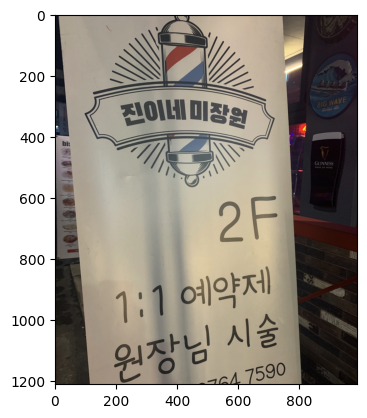

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('../02.jpg', cv2.IMREAD_COLOR)
b, g, r = cv2.split(img)
image =cv2.merge([r,g,b])

plt.imshow(image)

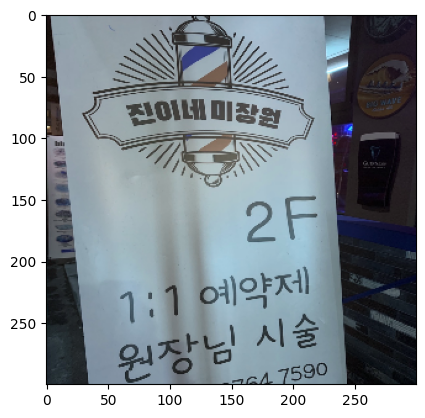

In [5]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('../02.jpg', cv2.IMREAD_COLOR)[:, :, ::-1]
img = cv2.resize(img, (300, 300))
b, g, r = cv2.split(img)
image =cv2.merge([r,g,b])

plt.imshow(image)

In [11]:
import numpy as np
np.ones((3, 4, 2))

array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]])